In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import pickle

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # Importing the SVM classifier
import matplotlib.pyplot as plt

# Setting display for visualizations
from sklearn import set_config; set_config(display='diagram')

In [12]:
from pathlib import Path
import pandas as pd

# Define the correct path based on your project structure
train_essays_path = Path("../raw_data/Legacy_AI_Text_Datasets/train_essays.csv")

# Check if the path exists
print(train_essays_path.exists())  # This should print True if the file is accessible

# Load the dataset
official_texts_df = pd.read_csv(train_essays_path)

# Display the first few rows
official_texts_df.head()

True


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [13]:
class_counts = official_texts_df['generated'].value_counts()

# Print the class counts
print(class_counts)

# Calculate the percentage of each class
class_percentage = official_texts_df['generated'].value_counts(normalize=True) * 100

# Print the percentage distribution
print(class_percentage)


generated
0    1375
1       3
Name: count, dtype: int64
generated
0    99.782293
1     0.217707
Name: proportion, dtype: float64


## Dataset Imbalance Analysis

Upon examining the class distribution in the `generated` column, it is evident that the dataset is highly imbalanced:

- **Class 0** (Human-written): 1375 samples (99.78%)
- **Class 1** (AI-generated): 3 samples (0.22%)

This imbalance poses a significant challenge for training a robust and unbiased machine learning model. With such a disproportionate ratio, the model is likely to become biased towards predicting the majority class (human-written), as it has very few instances of the minority class (AI-generated) to learn from.

### Next Steps

Given the extreme imbalance in the dataset, we will explore other datasets that have a more balanced distribution of AI-generated and human-written texts. This will allow us to train a more effective and generalized model capable of accurately distinguishing between human and AI-generated content.

In [21]:
# Read the CSV file for Train_v2_drcat and check its columns
df_train_v2_drcat = pd.read_csv("../raw_data/New Datasets/train_v2_drcat_02.csv")
print(df_train_v2_drcat.columns)

Index(['text', 'label', 'prompt_name', 'source', 'RDizzl3_seven'], dtype='object')


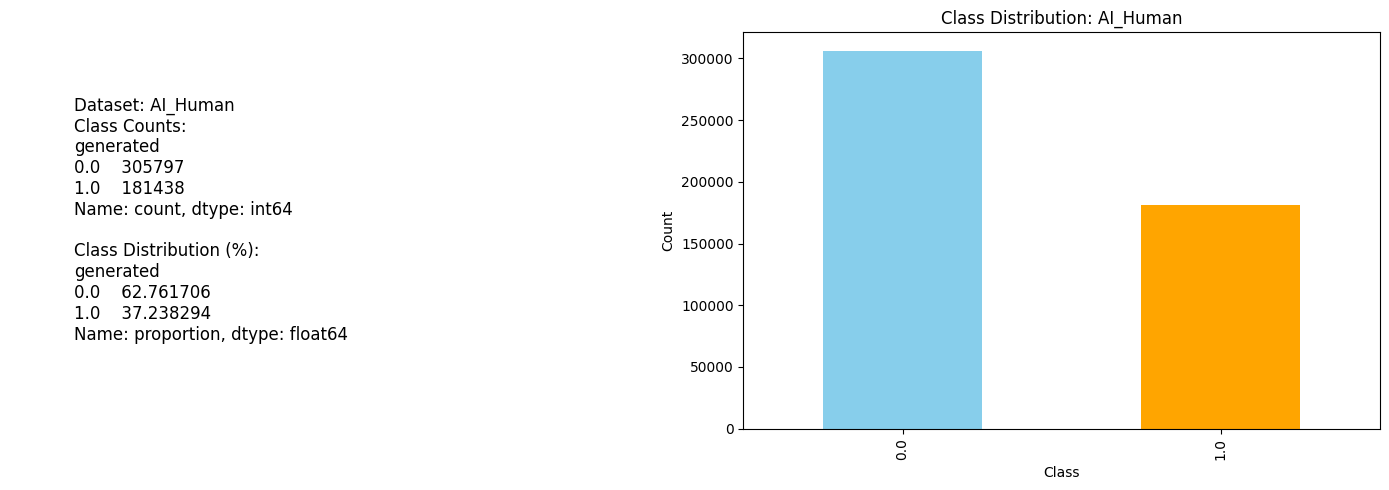

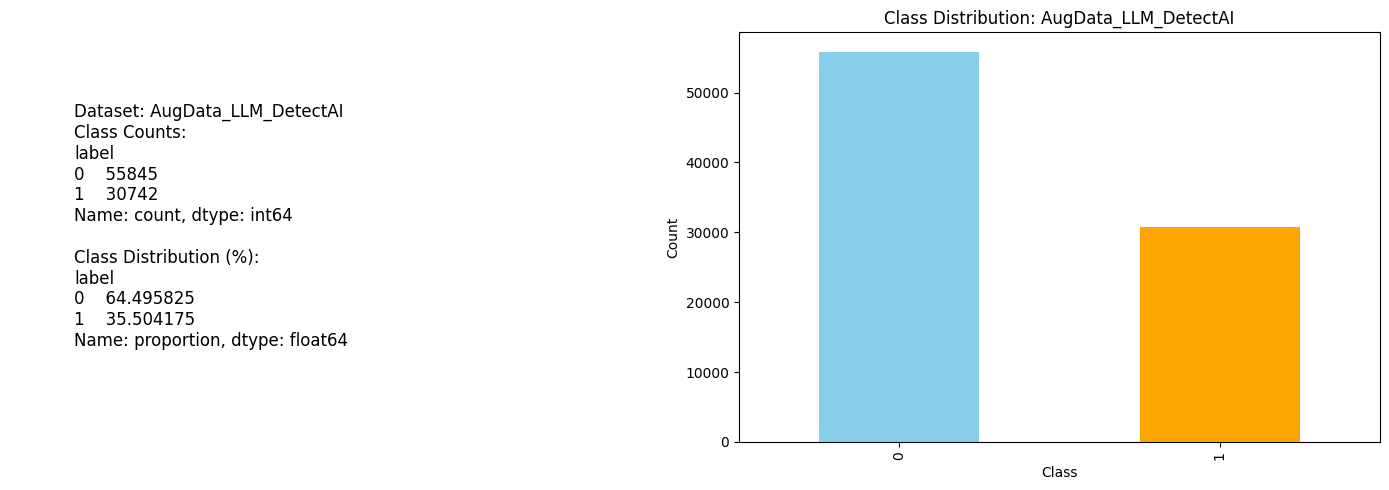

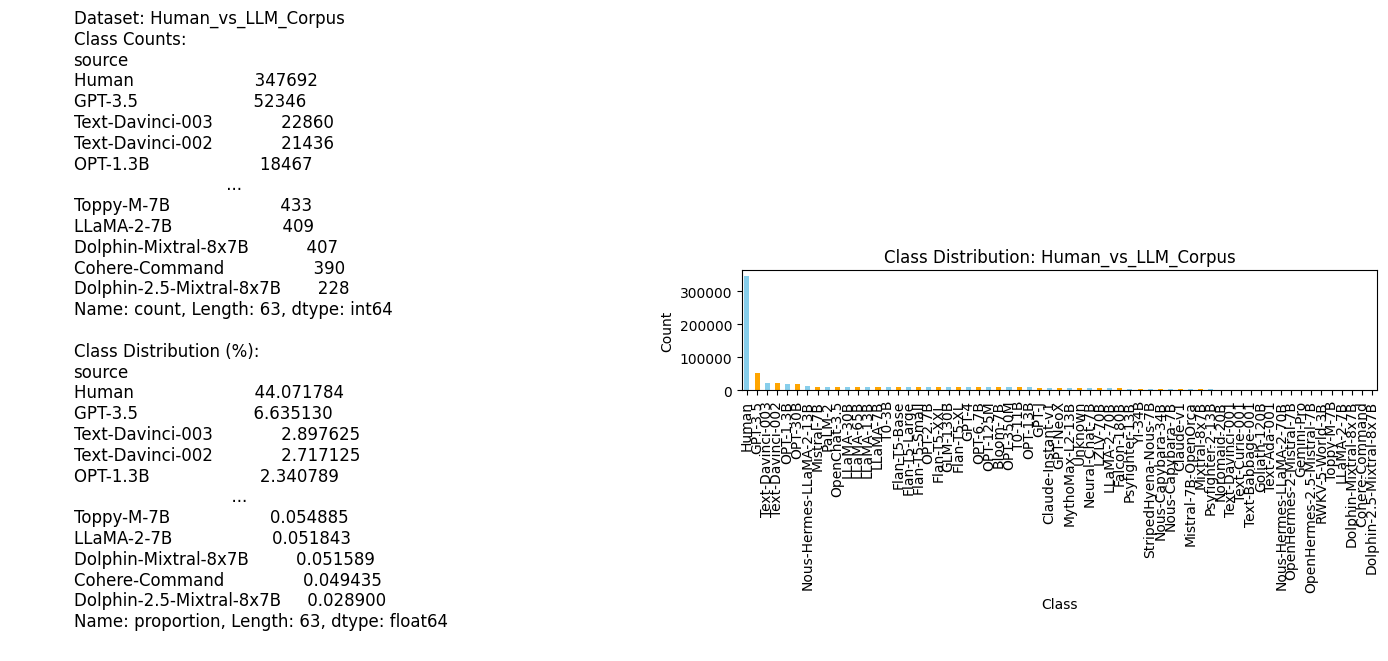

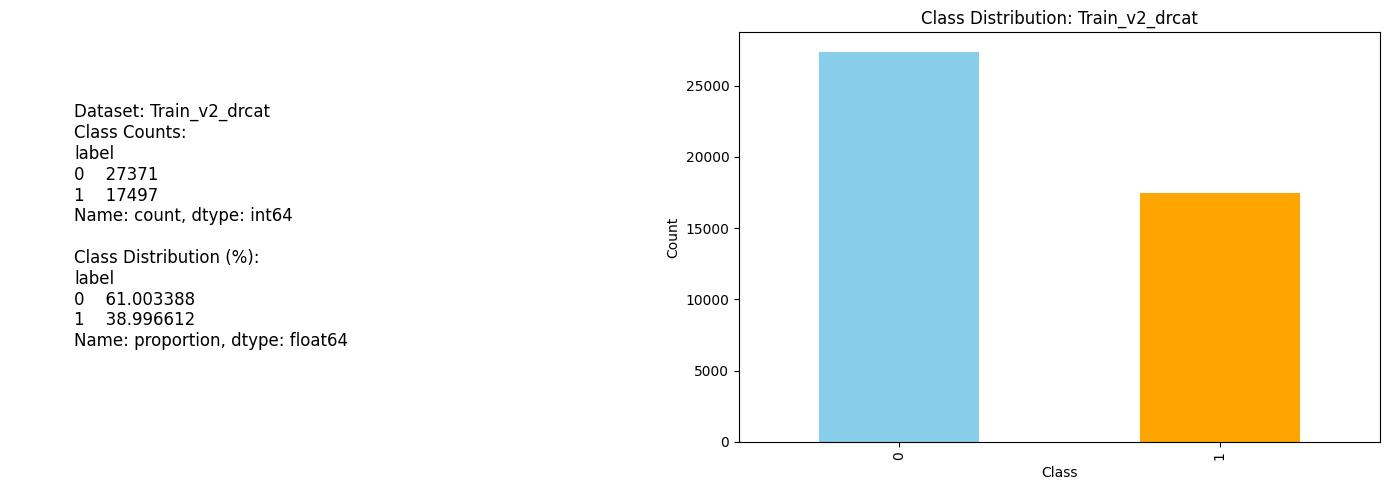

In [29]:
def check_imbalance(file_path, label_column, dataset_name):
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Calculate the counts and proportions based on the label column
    class_counts = df[label_column].value_counts()
    class_percentage = df[label_column].value_counts(normalize=True) * 100
    
    # Create a subplot grid with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Print the numerical output on the left
    ax1.axis('off')  # Hide the axis for the text plot
    table_text = (f"Dataset: {dataset_name}\n"
                  "Class Counts:\n"
                  f"{class_counts}\n\n"
                  "Class Distribution (%):\n"
                  f"{class_percentage}\n")
    ax1.text(0.1, 0.5, table_text, fontsize=12, va='center')
    
    # Plot the class distribution on the right
    class_counts.plot(kind='bar', color=['skyblue', 'orange'], ax=ax2)
    ax2.set_title(f'Class Distribution: {dataset_name}')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
    
    # Adjust layout to ensure everything fits well
    plt.tight_layout()
    plt.show()

# Define the paths and labels for each dataset
datasets = {
    "AI_Human": {"path": "../raw_data/New Datasets/AI_Human.csv", "label": "generated"},
    "AugData_LLM_DetectAI": {"path": "../raw_data/New Datasets/AugData_LLM_DetectAI/final_test.csv", "label": "label"},
    "Human_vs_LLM_Corpus": {"path": "../raw_data/New Datasets/Human_vs_LLM_Corpus/data.csv", "label": "source"},
    "Train_v2_drcat": {"path": "../raw_data/New Datasets/train_v2_drcat_02.csv", "label": "label"}
}

# Iterate through each dataset and display its analysis and plot
for dataset_name, info in datasets.items():
    check_imbalance(info["path"], info["label"], dataset_name)

## Imbalance Analysis Summary

1. **AI_Human Dataset:**
   - The dataset contains a significant imbalance, with approximately **62.76%** of the entries being human-generated and only **37.24%** being AI-generated. This imbalance could influence model training and bias predictions toward the majority class.

2. **AugData_LLM_DetectAI Dataset:**
   - This dataset shows a similar imbalance pattern, with around **64.50%** of the data being human-generated and **35.50%** being AI-generated. Although the imbalance is slightly less severe than the AI_Human dataset, it is still noteworthy.

3. **Human_vs_LLM_Corpus Dataset:**
   - This dataset is more diverse, containing multiple classes, with the majority (**44.07%**) being human-generated. Other classes represent various AI models, with **GPT-3.5** being the next most significant group at **6.63%**. The diversity in sources and the broader range of classes can provide a more comprehensive training set, but the imbalance still exists between human and AI sources.

4. **Train_v2_drcat Dataset:**
   - This dataset is also imbalanced, with **61.00%** of entries falling under one category (Category 0) and **39.00%** under the other (Category 1). While the imbalance is less severe, it could still impact training if not handled appropriately.

| **Dataset**              | **Class/Source**      | **Count** | **Percentage (%)** |
|-------------------------|-----------------------|-----------|--------------------|
| **AI_Human**            | 0.0 (Human)           | 305,797   | 62.76              |
|                         | 1.0 (AI)              | 181,438   | 37.24              |
| **AugData_LLM_DetectAI**| 0 (Human)             | 55,845    | 64.50              |
|                         | 1 (AI)                | 30,742    | 35.50              |
| **Human_vs_LLM_Corpus** | Human                 | 347,692   | 44.07              |
|                         | GPT-3.5               | 52,346    | 6.63               |
|                         | Text-Davinci-003      | 22,260    | 2.90               |
|                         | Text-Davinci-002      | 21,436    | 2.72               |
|                         | OPT-1.3B              | 18,467    | 2.34               |
|                         | ...                   | ...       | ...                |
| **Train_v2_drcat**      | 0 (Category 0)        | 27,371    | 61.00              |
|                         | 1 (Category 1)        | 17,497    | 39.00              |